In [6]:
import sys
import os
sys.path.append('../../EMAworkbench/') # or whatever your directory is

from IPython.core import display as ICD

import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rf
import seaborn as sns
import numpy as np
import pandas as pd
import random

from ema_workbench import (perform_experiments, ema_logging, save_results, 
                           load_results)
from ema_workbench.em_framework import samplers
from ema_workbench.em_framework import sample_levers

# turn on logging
ema_logging.log_to_stderr(ema_logging.INFO)

from start_run import models
from util import modelTitle
import charting


In [2]:
import matplotlib.ticker as ticker  

fs = 12

def setup_parallel_plot(labels, maxima, minima, new_labels, rot=0):
    #labels is a list, minima and maxima pd series
    nr_columns = len(labels)
    fig = plt.figure()
    axes = []
    
    # we need one axes less than the shape
    for i, label in enumerate(labels[:-1]):
        i += 1
        ax = fig.add_subplot(1,nr_columns-1,i,  ylim=(-0.1,1.1))
        axes.append(ax)
        ax.set_xlim([i,i+1])
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        if new_labels:
            ax.xaxis.set_ticklabels([new_labels[i-1]]) #, rotation=90)
        else:
            ax.xaxis.set_ticklabels([labels[i-1]], rotation=rot)
            

        ax.xaxis.set_tick_params(bottom=False, top=False)
        
        #let's put our own tick labels
        ax.yaxis.set_ticks([])
        ax.text(i, ax.get_ylim()[1]+0.01, "{:.2f}".format(maxima[label]), ha="center", fontsize=fs)
        ax.text(i, ax.get_ylim()[0]-0.01,"{:.2f}".format(minima[label]), ha="center", fontsize=fs)
        
        ax.spines['left'].set_bounds(0, 1)
        ax.spines['right'].set_bounds(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    
    # for the last axis, we need 2 ticks (also for the right hand side
    ax.spines['right'].set_bounds(0, 1)
    ax.xaxis.set_major_locator(ticker.FixedLocator([i, i+1]))
    if new_labels:
        ax.xaxis.set_ticklabels(new_labels[i-1:i+1], fontsize=fs)
    else:
        ax.xaxis.set_ticklabels(labels[i-1:i+1], fontsize=fs)
    ax.text(i+1, ax.get_ylim()[1]+0.01, "{:.2f}".format(maxima[labels[-1]]), ha="center", fontsize=fs)
    ax.text(i+1, ax.get_ylim()[0]-0.01,"{:.2f}".format(minima[labels[-1]]), ha="center", fontsize=fs)
    
    # add the tick labels to the rightmost spine
    for tick in ax.yaxis.get_major_ticks():
        tick.label2On=True
    
    # stack the subplots together
    plt.subplots_adjust(wspace=0)
    
    return axes


def normalize(data, minima, maxima):
    #takes pandas dataframe as data, and series as minima and maxima
    d = maxima - minima
    d[d==0] = 1
    norm_data = data.copy()
    for col in data.columns:
        norm_data[col] = (data[col]-minima[col])/d[col]
    #norm_data = data/d - minima/d
    return norm_data

def change_fontsize(fig, fs=14):
    '''Change fontsize of figure items to specified size'''
    # TODO:: add legend and general text items

    for ax in fig.axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                      ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fs)
        
        try:
            parasites = ax.parasites
        except AttributeError:
            pass
        else:
            for parisite in parasites:
                for axis in parisite.axis.values():
                    axis.major_ticklabels.set_fontsize(fs)
                    axis.label.set_fontsize(fs)

            for axis in ax.axis.values():
                axis.major_ticklabels.set_fontsize(fs)
                axis.label.set_fontsize(fs)
        
        if ax.legend_ != None:
            for entry in ax.legend_.get_texts():
                entry.set_fontsize(fs)

def save_fig(fig, dir, name):
    '''save a high res and a low res version of the figure in the specified
    directory, using the label i.
    
    Parameters
    ----------
    fig : a Figure instance
    dir : str
          the directory where figures are to be saved
    name : str
    
    '''
    
    fig.savefig('{}/fig{}_lowres.png'.format(dir, name), dpi=75, 
                bbox_inches='tight', format='png')
    fig.savefig('{}/fig{}_highres.png'.format(dir, name), dpi=300, 
                bbox_inches='tight', format='png')                  


In [3]:
class Character(object):
    '''
    returns a character in the order of the alphabet    
    '''

    def __init__(self):
        self.counter = -1
        
    def __call__(self, kwargs):
        self.counter += 1
        if self.counter == 26: 
            self.counter = 0
        return chr(ord('a') + self.counter)

In [7]:
# perform experiments
nr_experiments = 500
nr_policies = 10
num_scenarios = 4
folder = './data/multi/scenarioselection/scens_pol10/'

results = {}
for key, model in models.items(): 
    if not os.path.exists(folder):
        os.makedirs(folder)

    fn = '{}{}_{}experiments_{}policies.tar.gz'.format(folder, key, nr_experiments, nr_policies)
    policies = sample_levers(model,  n_samples=nr_policies, name=Character())

    try:
        # why regenerate the data?
        results[key] = load_results(fn)
    except IOError:
        results[key] = perform_experiments(model, nr_experiments, policies=policies)
        save_results(results[key], fn)
        
randomSelected = []
for x in range(num_scenarios):
    randomSelected.append((random.randint(0,nr_experiments * nr_policies-1)))

randomSelected.sort()
randomSelected

# 10 policies
maxDiverse = {
    'dps':[ 5, 61, 237, 312],
    'adaptivedirect':[ 0, 8, 28, 30],
    'intertemporal':[ 249, 344, 434, 492]
}

[MainProcess/INFO] results loaded succesfully from /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/dps_500experiments_10policies.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/plannedadaptive_500experiments_10policies.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/intertemporal_500experiments_10policies.tar.gz


### Step 2.2: Select policy relevant scenarios based on the exploration results:

In [9]:
newResults = {}
logicalIndex = {}

for key, model in models.items(): 
    print(key)
    experiments, outcomes = results[key]
    #here, the policy-relevant scenarios defined by median thresholds are selected
    indices = []
    for outcome in model.outcomes:
        if outcome.kind == -1:
            print(outcome.name, np.median(outcomes[outcome.name]),np.mean(outcomes[outcome.name]),
                  np.min(outcomes[outcome.name]),np.max(outcomes[outcome.name]))
            a = outcomes[outcome.name] > np.mean(outcomes[outcome.name])     
        else: 
            print(outcome.name, np.median(outcomes[outcome.name]),np.mean(outcomes[outcome.name]),
                  np.min(outcomes[outcome.name]),np.max(outcomes[outcome.name]))
            a = outcomes[outcome.name] < np.mean(outcomes[outcome.name])
        indices.append(a)
    indices = np.swapaxes(indices, 0, 1)
    logical_index = np.array([index.all() for index in indices])
    logicalIndex[key] = logical_index

    new_fn = '{}{}_meanselected_{}experiments_{}policies.tar.gz'.format(folder, key, nr_experiments, nr_policies)
    try:
        # why regenerate the data?
        newResults[key] = load_results(new_fn)
        print(key, newResults[key][0].shape)

    except IOError:
        newExperiments = experiments[logical_index]
        newOutcomes = {}
        for outcome in model.outcomes:
            newOutcomes[outcome.name] = outcomes[outcome.name][logical_index]

        newResults[key] = newExperiments, newOutcomes
#         save_results(newResults[key], new_fn)

#         print(key)
        print(newResults[key][0].shape)

#     except: 
#         print('skipping', key)

[MainProcess/INFO] results loaded succesfully from /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/dps_meanselected_500experiments_10policies.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/plannedadaptive_meanselected_500experiments_10policies.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/intertemporal_meanselected_500experiments_10policies.tar.gz


dps
max_P 3.4505412578582764 3.8071089227378367 0.1868215799331665 9.628036499023438
utility 0.957859992980957 1.126999996137619 0.2919610142707825 2.583167552947998
inertia 0.9898989796638488 0.9798354024648667 0.9191918969154358 0.9898989796638488
reliability 0.07056666910648346 0.2206623998168856 0.019999999552965164 1.0
dps (451,)
plannedadaptive
max_P 3.474516987800598 3.769499117936194 0.049508731812238686 9.39769458770752
utility 0.9489880800247192 1.101187126237154 0.05894977599382401 2.580477714538574
inertia 0.9898989796638488 0.988780570435524 0.9451178312301636 1.0
reliability 0.07999999821186066 0.23095219981577247 0.015266667120158672 1.0
plannedadaptive (110,)
intertemporal
max_P 3.0012447834014893 3.028948780527711 0.12707339227199554 8.9909029006958
utility 0.5037438869476318 0.5908226154029369 0.2610149085521698 1.4109252691268919
inertia 0.17676767706871033 0.17676767706871033 0.09090909361839294 0.2525252401828766
reliability 0.15880000591278076 0.4139064399320632 0

In [54]:
dfs = []

df = pd.DataFrame(newResults['dps'][0])
dfs.append(df[['b','q','mean','stdev','delta','model']])

df = pd.DataFrame(newResults['plannedadaptive'][0])
df['model'] = 'plannedadaptive'
dfs.append(df[['b','q','mean','stdev','delta','model']])

df = pd.DataFrame(newResults['intertemporal'][0])
dfs.append(df[['b','q','mean','stdev','delta','model']])

uncs = pd.concat(dfs)

In [57]:
vals = []
for model in ['intertemporal','plannedadaptive','dps']:
    d = uncs.loc[uncs['model']==model]
    for unc in ['b','q','mean','stdev','delta']: 
        
        df = pd.DataFrame(d[unc])
        df.columns = ['value']
        df['model'] = model
        df['uncertainty'] = unc
        vals.append(df)
uncs = pd.concat(vals)
uncs.columns

Index(['value', 'model', 'uncertainty'], dtype='object')

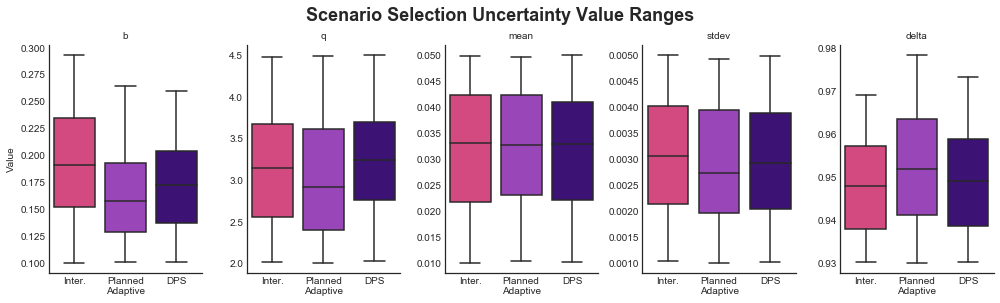

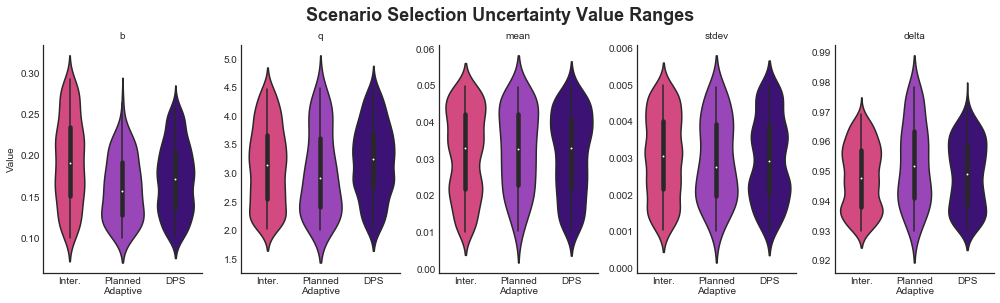

In [67]:
primaryColors = charting.primaryColors
sns.set_style('white')
pal = {'intertemporal': primaryColors['intertemporal']['multi'],
       'plannedadaptive': primaryColors['adaptivedirect']['multi'],
       'dps': primaryColors['dps']['multi']}
for tp in ['box','violin']: 
    g = sns.factorplot(x="model", y="value", col="uncertainty", palette=pal,
                       data=uncs, kind=tp, sharey=False,sharex=True,
                       size=4, aspect=.7)
    g.set_axis_labels('', "Value").set_titles("{col_name}").set_xticklabels(['Inter.','Planned\nAdaptive','DPS'])

    plt.suptitle('Scenario Selection Uncertainty Value Ranges', fontsize=18,weight='bold',y=1.05)

    save_fig(g, 'images/', 'leverranges_' + tp + '_' + 'scens')

    plt.show()

In [6]:
newResults = {}
logicalIndex = {}

for key, model in models.items(): 
    print(key)
    experiments, outcomes = results[key]
    #here, the policy-relevant scenarios defined by median thresholds are selected
    indices = []
    for outcome in model.outcomes:
        if outcome.kind == -1:
            print(outcome.name, np.median(outcomes[outcome.name]),np.mean(outcomes[outcome.name]))
            a = outcomes[outcome.name] > np.median(outcomes[outcome.name])     
        else: 
            print(outcome.name, np.median(outcomes[outcome.name]),np.mean(outcomes[outcome.name]))
            a = outcomes[outcome.name] < np.median(outcomes[outcome.name])
        indices.append(a)
    indices = np.swapaxes(indices, 0, 1)
    logical_index = np.array([index.all() for index in indices])
    logicalIndex[key] = logical_index

    new_fn = '{}{}_selected_{}experiments_{}policies.tar.gz'.format(folder, key, nr_experiments, nr_policies)
    try:
        # why regenerate the data?
        newResults[key] = load_results(new_fn)
        print(key, newResults[key][0].shape)

    except IOError:
        newExperiments = experiments[logical_index]
        newOutcomes = {}
        for outcome in model.outcomes:
            newOutcomes[outcome.name] = outcomes[outcome.name][logical_index]

        newResults[key] = newExperiments, newOutcomes
        save_results(newResults[key], new_fn)

        print(key)
        print(newResults[key][0].shape)

#     except: 
#         print('skipping', key)

[MainProcess/INFO] results loaded succesfully from /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/dps_selected_500experiments_10policies.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/adaptivedirect_selected_500experiments_10policies.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/intertemporal_selected_500experiments_10policies.tar.gz


dps
max_P 3.4505412578582764 3.8071089227378367
utility 0.957859992980957 1.126999996137619
inertia 0.9898989796638488 0.9798354024648667
reliability 0.07056666910648346 0.2206623998168856
dps (331,)
adaptivedirect
max_P 3.474516987800598 3.769499117936194
utility 0.9489880800247192 1.101187126237154
inertia 0.9898989796638488 0.988780570435524
reliability 0.07999999821186066 0.23095219981577247
adaptivedirect (40,)
intertemporal
max_P 3.0012447834014893 3.028948780527711
utility 0.5037438869476318 0.5908226154029369
inertia 0.17676767706871033 0.17676767706871033
reliability 0.15880000591278076 0.4139064399320632
intertemporal (508,)


In [7]:
prim_box = {'dps': {'b' : (0.100370, 0.408809), 
                    'delta': (0.930044,0.945124),
                    'r2': (0.072440,1.761488)}, 
            'adaptivedirect': {'b' : (0.100637, 0.402237), 
                               'delta': (0.930046,0.944981)},
            'intertemporal': {'b' : (0.100240, 0.325112), 
                              'delta': (0.930061,0.973927)}
           }

# MEDIAN Values
# prim_box = {'dps': {'b' : (0.100370, 0.239250), 
#                     'delta': (0.930044, 0.959158),
#                     'q': (2.001502, 4.145256), 
#                     'c1': (-0.104005, 1.731693)}, 
#             'adaptivedirect': {'b' : (0.100637, 0.402237), 
#                                'delta': (0.930046,0.944981)},
#             'intertemporal': {'b' : (0.100240, 0.261456), 
#                               'delta': (0.930061,0.959012), 
#                               'q' : (2.001704, 4.207757),
#                               'l1' : (0.006307, 0.088614), 
#                               'l11' : (0.001967, 0.088614),
#                               'l12' : (0.000645, 0.088072),
#                               'l13' : (0.008911, 0.091266)}
#            }


In [8]:
primIndex = {}
primResults = {}
for modelkey, model in models.items(): 
    print(modelkey)
    experiments, outcomes = results[modelkey]
    
    prim_indices = []
    for key, value in prim_box[modelkey].items():  
        a_ = experiments[key] >= value[0]
        b_ = experiments[key] <= value[1]
        c = [np.array([a, b]).all() for a, b in zip(a_, b_)]
        prim_indices.append(c)
#         else: 
#             if outcome.kind == -1:
#                 print(outcome.name, np.mean(outcomes[outcome.name]), np.median(outcomes[outcome.name]))
#                 a = outcomes[outcome.name] > np.median(outcomes[outcome.name])     
#             else: 
#                 print(outcome.name, np.mean(outcomes[outcome.name]), np.median(outcomes[outcome.name]))
#                 a = outcomes[outcome.name] < np.median(outcomes[outcome.name])
#             prim_indices.append(a)

    prim_indices = np.swapaxes(prim_indices, 0, 1)
    prim_logical_index = np.array([index.all() for index in prim_indices])
    
    newExperiments = experiments[prim_logical_index]
    newOutcomes = {}
    for outcome in model.outcomes:
        newOutcomes[outcome.name] = outcomes[outcome.name][logical_index]
        
    print(newExperiments.shape)
    primResults[modelkey] = newExperiments, newOutcomes
    primIndex[modelkey] = prim_logical_index

    new_fn = '{}{}_primselected_{}experiments_{}policies.tar.gz'.format(folder, modelkey, nr_experiments, nr_policies)
    save_results(primResults[modelkey], new_fn)

[MainProcess/INFO] results saved successfully to /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/dps_primselected_500experiments_10policies.tar.gz
[MainProcess/INFO] results saved successfully to /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/adaptivedirect_primselected_500experiments_10policies.tar.gz


dps
(999,)
adaptivedirect
(1050,)
intertemporal
(2380,)


[MainProcess/INFO] results saved successfully to /Users/eebart/Coursework/Year2/Thesis/Dev/ThesisWorking/deep_run/data/multi/scenarioselection/scens_pol10/intertemporal_primselected_500experiments_10policies.tar.gz


In [36]:
import random
import copy

key='intertemporal'
num_scenarios = 4

experiments, outcomes = results[key]
oois = sorted(outcomes.keys())

imageFolder = 'images/scenarioselect/policy10/'+key+'/'
if not os.path.exists(imageFolder):
    os.makedirs(imageFolder)

### Run PRIM

In [ ]:
import ema_workbench.analysis.prim as prim

robustBorders = {
    'max_P':0.75,
    'reliability':0.99,
    'utility':0.75, 
    'inertia':1 #0.8
}

def classify(data):
    # This function specifies the scenarios of interest as failure scenarios according to the median thresholds
    oois = data.keys()
    indices = []
    for ooi in oois:
        if ooi in ['max_P']:
            if not ooi in robustBorders: 
                a = data[ooi] > np.median(data[ooi])
            else: 
                a = data[ooi] > robustBorders[ooi]
        else: 
            if not ooi in robustBorders: 
                a = data[ooi] < np.median(data[ooi])
            else: 
                a = data[ooi] < robustBorders[ooi]
        indices.append(a)
    indices = np.swapaxes(indices, 0, 1)
    classes = np.array([index.all() for index in indices])
    
    return classes

In [ ]:
prim_obj = prim.setup_prim(results[key], classify, threshold=0.8, threshold_type=1)
box_1 = prim_obj.find_box()

In [ ]:
# box_1.show_ppt()
sns.set_style('white')
h = box_1.show_tradeoff()
plt.show()

In [ ]:
box_1.peeling_trajectory

In [ ]:
box_1.inspect(14)

In [ ]:
box_2 = prim_obj.find_box()

In [ ]:
box_2.peeling_trajectory

### Processing

In [37]:
sel_column = logicalIndex[key].astype(int)

count = 0
for index, i in enumerate(sel_column):
    if prim_logical_index[index]: #this is computed at the bottom of  the notebook
        sel_column[index] = 2
            
    if index in randomSelected:
        sel_column[index] = 3
        
    if i:
        if count in maxDiverse[key]:
            sel_column[index] = 4
        count +=1

data = copy.copy(outcomes)
data['selected'] = sel_column
data = pd.DataFrame(data)

set(sel_column)

{0, 1, 2, 3, 4}

In [38]:
exper = pd.DataFrame(experiments)
df = pd.concat([exper, data], axis=1, join_axes=[data.index])

print('Maximally diverse scenarios')
diverse = df[df['selected']==4][['b','q','delta','mean', 'stdev']]
ICD.display(diverse)
diverse.to_csv(imageFolder + key + '_maxdiverse.csv',index=False)

Maximally diverse scenarios


,b,q,delta,mean,stdev
3324,0.276035,3.049007,0.931006,0.028542,0.003876
3761,0.135001,2.025535,0.961300,0.040695,0.002932
4666,0.270389,2.478273,0.963129,0.016897,0.003903
4919,0.100908,3.678865,0.931705,0.018745,0.003688


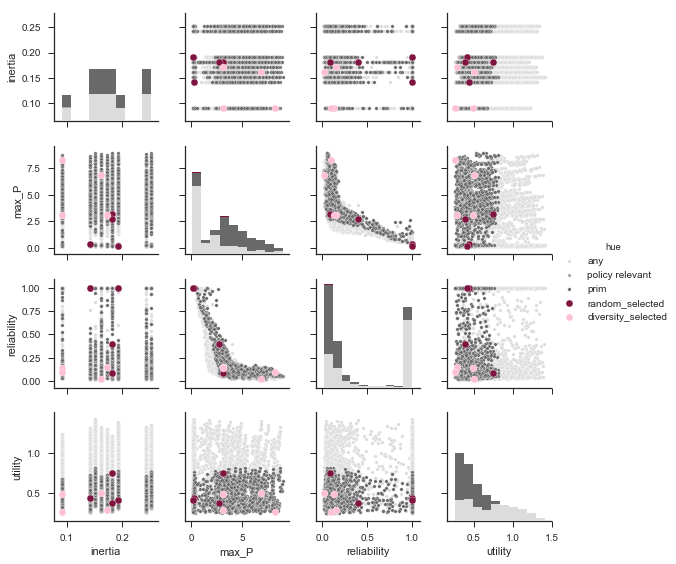

In [39]:
sns.set(style="ticks", color_codes=True)
sns.axes_style('white')
colors = ['#DCDCDC', '#A9A9A9', '#696969', charting.fullColors[key]['multi'][3], charting.fullColors[key]['multi'][0]]

titles = ['any', 'policy relevant', 'prim', 'random_selected', 'diversity_selected']
for idx in range(5): 
    data.loc[data['selected']==idx, 'hue'] = titles[idx]
    
g = sns.pairplot(data, hue='hue', size=2, markers = ['.', '.','.', 'o', 'o'],
             palette=colors, hue_order=titles, vars=oois)

tag_indices = {0: 'inertia', 1: 'max_P', 2: 'reliability', 3: 'utility'}

save_fig(g, dir=imageFolder, name=key + '_pairplot.png')
plt.show()

## Plot the selected four scenarios

In [ ]:
sns.set(style="ticks", color_codes=True)    
sns.set_style('white', {'axes.edgecolor':'lightgrey'})

ref = {'b':.42,'delta':.98,'mean':0.02,'q':2,'stdev':0.0017}

def parallel_plot_selected_annotated(data, scenarios, title, t=1):
    max_p, utility, inertia, reliability = models[key].function()
    baseRef = {'b':.42,'delta':.98,'mean':0.02,'q':2,'stdev':0.0017, 'max_P':max_p, 'utility':utility,'inertia':inertia,'reliability':reliability}
    baseRef = pd.DataFrame([baseRef])
    
    tags = ['1','2','3','4']
    scenarioTags = {'Ref': 'Ref'}
    for idx, val in enumerate(scenarios):
        scenarioTags[val] = tags[idx]
    
    experiments, outcomes = data
    labels = ['b', 'q', 'delta', 'mean', 'stdev'] + sorted(list(outcomes.keys()))
    
    df_outcomes = pd.DataFrame.from_dict(outcomes)
    df_outcomes = df_outcomes.sort_index(axis=1)
    df_experiments = pd.DataFrame(experiments)
    df_experiments = df_experiments[['b', 'q', 'delta', 'mean', 'stdev']]
    
    df = pd.concat([df_experiments, df_outcomes], axis=1, join_axes=[df_outcomes.index])
    df = pd.concat([df, baseRef]).reset_index(drop=True)

    minima = np.min(df, axis=0)
    maxima = np.max(df, axis=0)

    for uncert in models[key].uncertainties: 
#         print(uncert.name)
#         print(vars(uncert))
        minima[uncert.name] = uncert.lower_bound
        maxima[uncert.name] = uncert.upper_bound
    
    axes = setup_parallel_plot(labels, maxima, minima, [])
    normed_data = normalize(df, minima, maxima)
    normed_ref = normalize(baseRef, minima, maxima)
    #normed_data = normed_data.sort_index(axis=1) #re-ordering the columns of the df to align the grid with the df
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    
    if normed_data.shape[0] > 500: 
        viewGray = normed_data.sample(500)
    else: 
        viewGray = normed_data
        
    colors = charting.fullColors[key]['multi']
    leg_labels = []
    some_identifiers = []
    for j in range(len(labels)-1):
        ax = axes[j]
        y = viewGray.ix[:, j:j+2]
        x = np.tile([j+1,j+2], (y.shape[0], 1))
        ax.plot(x.T, y.T, color='grey', linewidth=0.3)
        
        y_selected = normed_ref.ix[0, j:j+2]
        ax.plot(x.T, y_selected.T, color=colors[0], lw=3)
        if j == 0:
            leg_labels.append("Scenario {}".format(scenarioTags['Ref']))
            artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[0], facecolor=colors[0])
            some_identifiers.append(artist)
        
        for i, s in enumerate(scenarios):
            y_selected = normed_data.ix[s, j:j+2]
            ax.plot(x.T, y_selected.T, color=colors[i+1], lw=3)
            if j == 0:
                if s in scenarioTags: 
                    leg_labels.append("Scenario {}".format(scenarioTags[s]))
                else: 
                    leg_labels.append("Scenario {}".format(s))
                artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[i+1], facecolor=colors[i+1])
                some_identifiers.append(artist)
            #plot lines below the axes
            if j < 4:
                ax.axhline(y=-0.4,xmin=0,xmax=1,c="black",linewidth=1,zorder=0, clip_on=False)
            elif j > 4:
                ax.axhline(y=-0.4,xmin=-0.5,xmax=1,c="black",linewidth=1,zorder=0, clip_on=False)
                
    plt.legend(some_identifiers, leg_labels, loc=2, bbox_to_anchor=(1.05, 0.9), borderaxespad=0., fontsize=13)
    plt.text(2.15, -0.5, "Deep uncertainties", fontsize=13)
    plt.text(6.35, -0.5, "Outcome indicators", fontsize=13)  
                     
    change_fontsize(fig, 12)
    save_fig(fig, dir=imageFolder, name=title)
    plt.show()

In [62]:
sns.set(style="ticks", color_codes=True)    
sns.set_style('white', {'axes.edgecolor':'lightgrey'})

ref = {'b':.42,'delta':.98,'mean':0.02,'q':2,'stdev':0.0017}

def parallel_plot_selected_annotated(data, scenarios, title, t=1):
    baseRef = {'b':.42,'delta':.98,'mean':0.02,'q':2,'stdev':0.0017}
    baseRef = pd.DataFrame([baseRef])
    
    tags = ['1','2','3','4']
    scenarioTags = {'Ref': 'Ref'}
    for idx, val in enumerate(scenarios):
        scenarioTags[val] = tags[idx]
    
    experiments, outcomes = data
    labels = ['b', 'q', 'delta', 'mean', 'stdev']
    df_experiments = pd.DataFrame(experiments)
    df_experiments = df_experiments[['b', 'q', 'delta', 'mean', 'stdev']]
    
#     df = pd.concat([df_experiments, df_outcomes], axis=1, join_axes=[df_outcomes.index])
    df = df_experiments
    df = pd.concat([df, baseRef]).reset_index(drop=True)

    minima = np.min(df, axis=0)
    maxima = np.max(df, axis=0)

    for uncert in models[key].uncertainties: 
#         print(uncert.name)
#         print(vars(uncert))
        minima[uncert.name] = uncert.lower_bound
        maxima[uncert.name] = uncert.upper_bound
    
    axes = setup_parallel_plot(labels, maxima, minima, [], 0)
    normed_data = normalize(df, minima, maxima)
    normed_ref = normalize(baseRef, minima, maxima)
    #normed_data = normed_data.sort_index(axis=1) #re-ordering the columns of the df to align the grid with the df
    fig = plt.gcf()
    fig.set_size_inches(8, 5)
    
    if normed_data.shape[0] > 500: 
        viewGray = normed_data.sample(500)
    else: 
        viewGray = normed_data
        
    colors = charting.fullColors[key]['multi']
    leg_labels = []
    some_identifiers = []
    for j in range(len(labels)-1):
        ax = axes[j]
        y = viewGray.ix[:, j:j+2]
        x = np.tile([j+1,j+2], (y.shape[0], 1))
        ax.plot(x.T, y.T, color='grey', linewidth=0.3)
        
        y_selected = normed_ref.ix[0, j:j+2]
        ax.plot(x.T, y_selected.T, color=colors[0], lw=3)
        if j == 3:
            leg_labels.append("Scenario {}".format(scenarioTags['Ref']))
            artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[4], facecolor=colors[4])
            some_identifiers.append(artist)
        
        for i, s in enumerate(scenarios):
            y_selected = normed_data.ix[s, j:j+2]
            ax.plot(x.T, y_selected.T, color=colors[i+1], lw=3)
            if j == 0:
                if s in scenarioTags: 
                    leg_labels.append("Scenario {}".format(scenarioTags[s]))
                else: 
                    leg_labels.append("Scenario {}".format(s))
                artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[i], facecolor=colors[i])
                some_identifiers.append(artist)
                
    plt.legend(some_identifiers, leg_labels, loc=2, bbox_to_anchor=(1.05, 0.9), borderaxespad=0., fontsize=13)
    plt.suptitle(modelTitle[key].replace('\n',' '))
    
    change_fontsize(fig, 12)
    save_fig(fig, dir=imageFolder, name=title)
    plt.show()

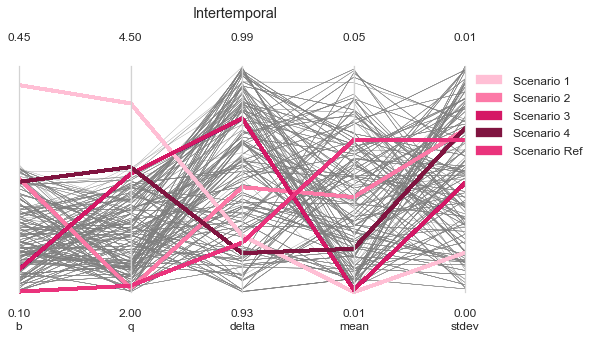

In [63]:
key='intertemporal'
parallel_plot_selected_annotated(newResults[key], maxDiverse[key], key + '_selected_maxdiverse_parallel')
# parallel_plot_selected_annotated(results[key], randomSelected, key + '_selected_random_parallel')

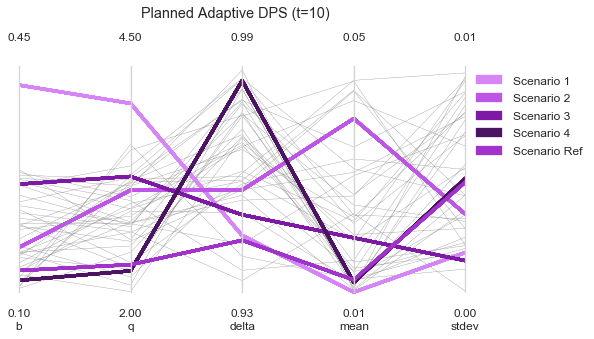

In [64]:
key='adaptivedirect'
parallel_plot_selected_annotated(newResults[key], maxDiverse[key], key + '_selected_maxdiverse_parallel')
# parallel_plot_selected_annotated(results[key], randomSelected, key + '_selected_random_parallel')

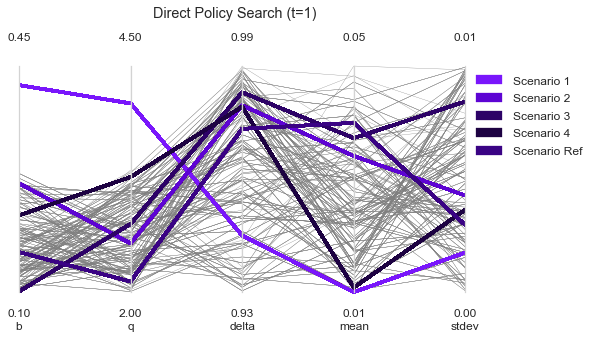

In [65]:
key='dps'
parallel_plot_selected_annotated(newResults[key], maxDiverse[key], key + '_selected_maxdiverse_parallel')
# parallel_plot_selected_annotated(results[key], randomSelected, key + '_selected_random_parallel')